### Cross validation for Inverse Power of distance

#### Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.spatial as sps
import os

#### Formato

In [2]:
def setfs ( s ):
    font = {'family' : 'Times New Roman',
            'weight' : 'normal',
            'size'   : s}
    matplotlib.rc('font', **font)
    
setfs ( 11 )    

#### Load Data

In [3]:
with open('samples.dat','r') as f:
    f.readline()
    ncols = int(f.readline())

In [4]:
data = pd.read_csv('samples.dat',header=None,skiprows=ncols+2,sep='\s+',na_values=-999)
print("Data loaded, size: ",data.values.shape,flush=True)
data.rename(columns={0:'DHID',1:'X',2:'Y',3:'Z',4:'Cut',5:'SG'}, inplace=True)                  # column edition
data.head()

Data loaded, size:  (1201, 6)


,DHID,X,Y,Z,Cut,SG
0,154,288562.5737,599030.776,408.22,0.13750,2.64
1,154,288560.8844,599031.222,408.22,0.53800,2.64
2,1,288437.1254,599370.391,404.85,2.53143,2.64
3,1,288439.0319,599370.992,404.85,1.20260,2.64
4,1,288444.6375,599373.115,404.85,2.30590,2.64


In [5]:
data=data.values                        # .Values transforma la dataframe.
ndata=data.shape[0]                     # Numeros de datos en el archivo de muestras.
y=data[:,4]                             # Valor del Punto a estimar.
q=data[0:,1:4]                          # Coordenadas de los puntos a estimar ( x,y.z).
ndata

1201

#### Visualización 

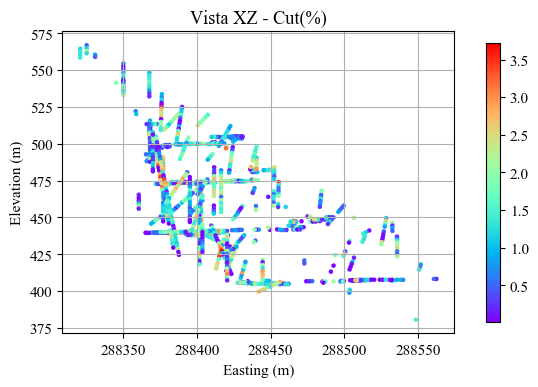

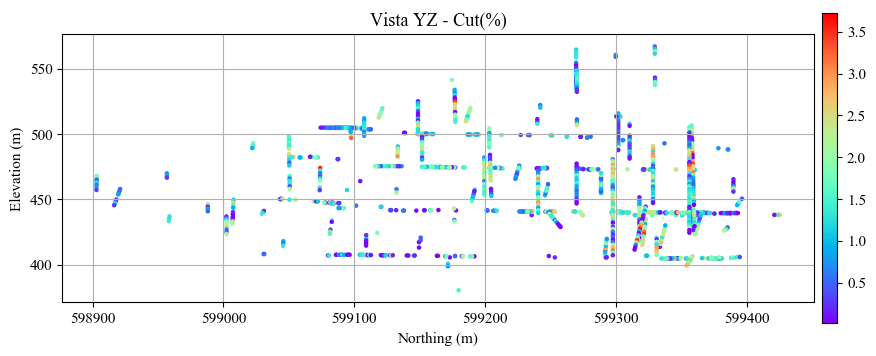

In [6]:
plt.figure(dpi=100)
plt.scatter(q[:,0],q[:,2],s=5,c=y,cmap='rainbow')
plt.colorbar(fraction=0.03,pad=0.01)
plt.axis('image')
plt.title('Vista XZ - Cut(%)')
plt.xlabel('Easting (m)')
plt.ylabel('Elevation (m)')
plt.grid()
plt.show()

plt.figure(dpi=100,figsize=(10,5))
plt.scatter(q[:,1],q[:,2],s=5,c=y,cmap='rainbow')
plt.colorbar(fraction=0.02,pad=0.01)
plt.axis('image')
plt.title('Vista YZ - Cut(%)')
plt.xlabel('Northing (m)')
plt.ylabel('Elevation (m)')
plt.grid()
plt.show()

#### Inverse distance weighted in cross validation mode

Y Mean:  1.229  Y_e Mean:  1.246
Y Var:  0.691  Y_e Var:  0.328
Correlation  0.547
R-squared  0.299
Slope:  0.793
Residual SS:  599.368


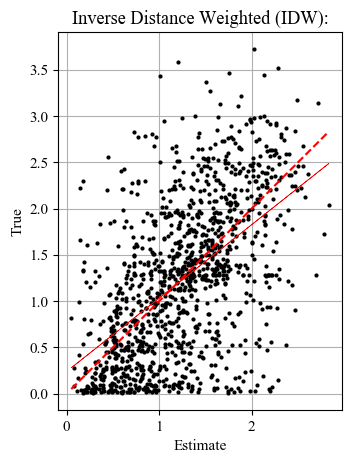

In [7]:
# Leyenda:
# q:Puntos para realizar la validacion cruzada
# nn: numero de muestras cercanas
# output : mostrar resultados
# p: exponente de potencia

def idw(q,nn,p,output):
    kdt=sps.KDTree(q)
    d, k=kdt.query(q,k=nn+2)
    y_e = np.zeros(y.shape)
    error = np.zeros(y.shape)
    ne = 0                                               # n° de muestra mas cercana no se utiliza
    for i in range(ndata):
        ki = k[i,0:]                                          
        dm = sps.distance_matrix(q[ki,:],q[ki,:])
        ji = k[i,(ne+1):]                                          
        if p>=0: 
            w= 1/(np.power(dm[0,(ne+1):],p))
            w1=w/(w.sum(axis=0))
            y_e[i]=y[ji]@ w1
            error[i]= y_e[i]-y[i]
    
    if output:
        print("Y Mean: ","{0:.3f}".format(np.mean(y))," Y_e Mean: ","{0:.3f}".format(np.mean(y_e)))
        print("Y Var: ","{0:.3f}".format(np.var(y))," Y_e Var: ","{0:.3f}".format(np.var(y_e)))
        print("Correlation ","{0:.3f}".format(np.corrcoef(y,y_e,rowvar=False)[0,1]))
        print("R-squared ","{0:.3f}".format((np.corrcoef(y,y_e,rowvar=False)[0,1])**2))

        X = np.concatenate((np.ones([ndata,1]),y_e[:,None]),axis=1)
        b = np.linalg.solve(X.T@X,X.T@y)
        yreg = X @ b

        print("Slope: ","{0:.3f}".format(b[1]))
        print("Residual SS: ","{0:.3f}".format(np.sum((y_e-y)**2)))

        plt.figure(figsize=(5,5),dpi=100)
        plt.plot(y_e,y,'k.',markersize=4)
        plt.plot(y_e,yreg,'r-',linewidth=0.5)
        plt.plot([y_e.min(),y_e.max()],[y_e.min(),y_e.max()],'r--')
        plt.xlabel('Estimate')
        plt.ylabel('True')
        plt.axis('image')
        plt.grid()
        plt.title('Inverse Distance Weighted (IDW):')
        plt.show()
    
    return y_e #, error                   
 
y_e = idw(q,10,2,True)                         

#### Error residual Versus IDW

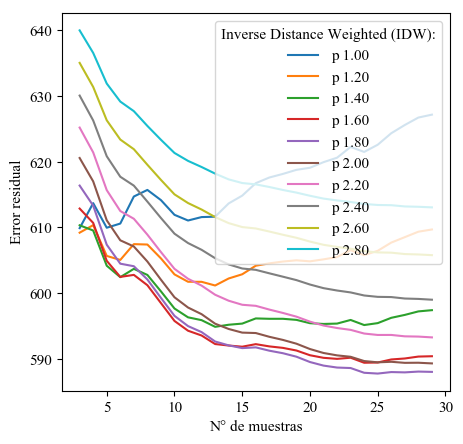

1.8 25 587.754
Y Mean:  1.229  Y_e Mean:  1.248
Y Var:  0.691  Y_e Var:  0.254
Correlation  0.545
R-squared  0.297
Slope:  0.898
Residual SS:  587.754


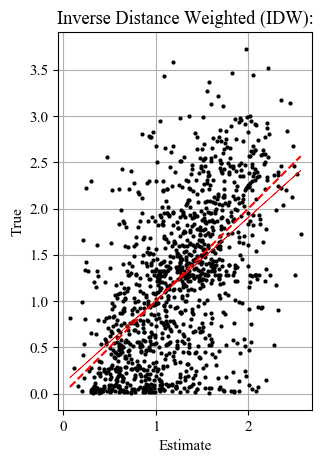

In [8]:
p0 = 0
nn0 = 0
e0 = 99999

plt.figure(figsize=(5,5),dpi=100)
    
for p in [1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8]:
    e = []
    for nn in range(3,30):
        y_e = idw(q,nn,p,False)
        e.append(np.sum((y_e-y)**2))                        # Se busca el menor error residual
        if e[-1] < e0:
            e0 = e[-1]
            nn0 = nn
            p0 = p
    e = np.asarray(e)
    plt.plot(range(3,30),e, label="p %.2f"%(p))
    plt.xlabel("N° de muestras")
    plt.ylabel("Error residual")
    plt.legend(loc="lower right")
    plt.legend(title='Inverse Distance Weighted (IDW):')
    
plt.show()

print(p0,nn0,'%.3f' %(e0))
y_e = idw(q,nn0,p0,True)

#### Correlacion Versus IDW

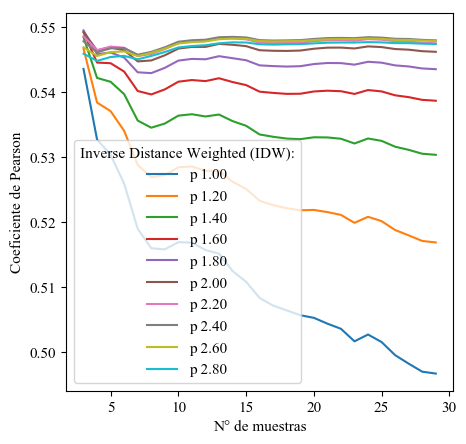

1.8 3 0.550
Y Mean:  1.229  Y_e Mean:  1.247
Y Var:  0.691  Y_e Var:  0.398
Correlation  0.549
R-squared  0.302
Slope:  0.724
Residual SS:  616.391


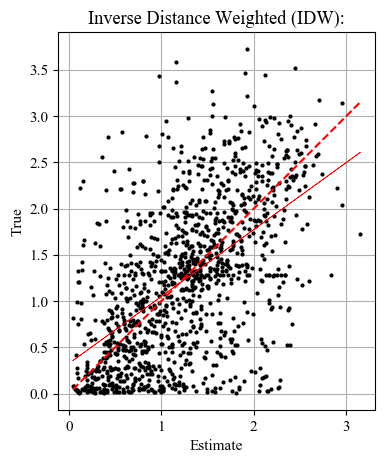

In [9]:
p0 = 0
nn0 = 0
e0 = 0

plt.figure(figsize=(5,5),dpi=100)
    
for p in [1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8]:
    e = []
    for nn in range(3,30):
        y_e = idw(q,nn,p,False)
        e.append(np.corrcoef(y,y_e,rowvar=False)[0,1])    # Se busca el menor Coeficiente de Pearson
        if e[-1] > e0:
            e0 = e[-1]
            nn0 = nn
            p0 = p
    e = np.asarray(e)
    plt.plot(range(3,30),e , label="p %.2f"%(p))
    plt.xlabel("N° de muestras")
    plt.ylabel("Coeficiente de Pearson")
    plt.legend(title='Inverse Distance Weighted (IDW):')

plt.show()

print(p0,nn0,'%.3f' %(e0))
y_e = idw(q,nn0,p0,True)

#### R-square Versus IDW

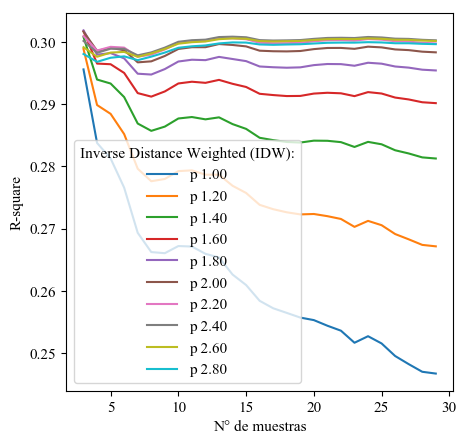

1.8 3 0.302
Y Mean:  1.229  Y_e Mean:  1.247
Y Var:  0.691  Y_e Var:  0.398
Correlation  0.550
R-squared  0.302
Slope:  0.724
Residual SS:  616.371


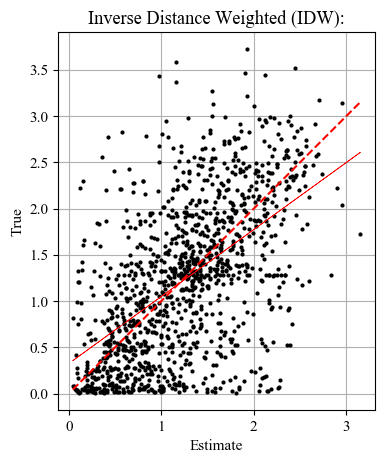

In [10]:
p0 = 0
nn0 = 0
e0 = 0

plt.figure(figsize=(5,5),dpi=100)
    
for p in [1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8]:
    e = []
    for nn in range(3,30):
        y_e = idw(q,nn,p,False)
        e.append(np.power(np.corrcoef(y,y_e,rowvar=False),2)[0,1])    # Se busca el menor R-square
        if e[-1] > e0:
            e0 = e[-1]
            nn0 = nn
            p0 = p
    e = np.asarray(e)
    plt.plot(range(3,30),e , label="p %.2f"%(p))
    plt.xlabel("N° de muestras")
    plt.ylabel("R-square")
    plt.legend(title='Inverse Distance Weighted (IDW):')

plt.show()

print(p0,nn0,'%.3f' %(e0))
y_e = idw(q,nn0,p0,True)

### Fin.